
# Implementing a Bass Booster in Python 


## Overview of Relevant Material:
Note: This overview is not meant to be comprehensive. It is hear to simply illustrate what concepts one would need to know in order to
implement this project as done in this notebook. It should point to further reading if one is not totally familiar with the
content presented in this section of the notebook.
### The FFT:
The fast Fourier transform (FFT) is used to implement the discrete Fourier transform (DFT). The DFT in turn is a
discrete sampling of the discrete time Fourier transform (DTFT). That's all to say -- the FFT is a fast algorithm which tells us the
frequency spectrum of a given signal. The DFT is a mapping between a time domain signal $x[n]$ and its frequency spectrum $X[k]$.
If $N$ is the size of our input signal $x[m]$, then the packages ```scipy``` and ```numpy``` implement the following DFT via the FFT:

\begin{align*}
X[k] & = \sum_{m=0}^{N-1} x[m] \exp\left( -2\pi j \frac{m k}{N} \right), \,\, k = 0,1,\dots,N-1 \\
x[m] & = \frac{1}{N} \sum_{k=0}^{N-1} X[k] \exp\left(2\pi j \frac{m k}{N}\right), \,\, m = 0,1,\dots, N-1
\end{align*}

When characterising signals we will often look at the **Power Spectral Density** (PSD) in this notebook.
The PSD is defined as follows. If $X[k]$ is our frequency spectrum then

$$\text{PSD} = \frac{X[k]\cdot X[k]^*}{N} = \frac{|X[k]|^2}{N} $$

This distribution tells us how much power corresponds to a given frequency component of our time domain signal.

Another quick note on the FFT: When implementing the DFT through the FFT it is important to understand how it returns frequency
content. The FFT does not return frequency content in the order we may want it to be in for plotting purposes. If $N$ is even, then the first $N/2$
components of the returned FFT will be the positive frequency components. The exact middle of the array (exactly $N/2$) will be the Nyquist component (DC) and the
last half of the components will be negative frequency content. It is a mostly similar situation if $N$ is odd, however $N/2$ will not be the Nyquist component and the
algorithm will be less efficient. For plotting purposes we therefore must shift the contents of the array returned by the FFT. This is why we use ```np.fft.fftshift()``` in the plotting sections.

Further, the FFT returns indexes not frequencies (there are functions that can return the frequency axis along with the FFT). Meaning the FFT, if plotted immediately after
shifting, will simply be a plot of magnitude against the FFT arrays indices. One way to get the frequency axis is to understand the [Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem).
The Sampling Theorem essentially states that if $x(t)$ has a bandwidth of $B$Hz then we can faithfully represent the signal with a sampling rate $f_2 > 2B$ samples a second.
The upper end of human hearing, on average, is around 20 kHz. This is why most audio files are sampled at a rate of 44100Hz so that the band on which we can
faithfully reconstruct the audio is $f \in [0,22050)\,\text{Hz}$. Even if the audio contains frequencies higher than this bandwidth, we don't care if the FFT
cannot meaningfully represent these frequencies, as they will not be processed by the human ear anyways. Thus a typical choice of frequency axis, for a given sampling frequency $f_s = 2B$ is

$$f \in [-f_s/2, f_s/2] $$

where $f$ is divided into $N$ equal points.

The final things to explain about the FFT are **spectral leakage** and **frequency scalloping**. When we pass a signal, say a .wav audio file, to the FFT we are effectively
applying a window of $w[n] = 1$ over the entire $N$ samples. Since the DFT expects a periodic signal as input, the signal is effectively infinite in duration, as $x[n] = x[n+T]$ for some integer $T$.
However when we pass in the raw data, it looks like we passed in some data, $a[n]$ in the form

$$a[n] = x[n]\cdot w[n] \text{ where } w[n] =1\, \forall 0\leq n \leq N  $$

This window will cause side lobing in the Frequency domain as the abrupt cutoff requires many frequencies to construct. Also note the FFT will enforce periodicity,
i.e if $x[0] \neq x[N-1]$, then the FFT will enforce that condition. This will cause inaccuracies in the discrete frequency representation of our signal and these inaccuracies are referred to as **spectral leakage**.
A process called **windowing** is usually undergone to correct for spectral leakage. While there is many types of windowing functions, for the purposes of
this project the differences between the most popular ones are not significant enough for us to spend a lot of time on. The goal of windowing is usually to enforce
periodicity on the input signal (x[0] = x[N-1]) while also minimizing side lobing in the frequency domain. For the purposes of this project, whenever data is passed
to the FFT a Blackman window is used:

$$w[n] = 0.42 - 0.5\cos\left(\frac{2\pi n}{N}\right) + 0.08\cos\left(\frac{4\pi n}{N}\right), \,\, 0 \leq n \leq N-1  $$

Notice that $w[n]$ is defined for the entire size of $x[n]$, a more sophisticated approach may involve making the window much smaller ([STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)) but we will not
worry about a more complicated windowing approach in this project.

### Butterworth Filters:
Butterworth filters will be used in this project. Thus a brief discussion of them is included here. Magnitude of the transfer function for an $n$-th order Butterworth low pass filter with cutoff
frequency $f_c$ is as follows:

$$ |H(j\omega)| = \frac{G_0}{\sqrt{1+\displaystyle \left( \frac{j \omega}{j\omega_c}\right)^n}}, \,\,\,\text{LPF}$$

where $G_0$ is the DC gain of the filter. The magnitude response of the high pass Butterworth filter of the same order is obtained by replacing $j\omega/j\omega_c$ with $j\omega_c/j\omega$
in the LPF formula:

$$ |H(j\omega)| = \frac{G_0}{\sqrt{1+\displaystyle \left( \frac{j\omega_c}{j\omega} \right)^n}}, \,\,\,\text{HPF} $$

Of course these are the continuous filter formulas, but the digital equivalents $H(z)$, from the original transfer functions $H(s)$ can easily be obtained
via the [bilinear transformation](https://en.wikipedia.org/wiki/Bilinear_transform) or another similar method. The resulting functionality is basically the same with some added complexities
due to the bilinear transformation (see frequency warping in hyperliked page).

Butterworth filters have the advantage of being simple, and they also have maximally flat pass bands with no ripple. This means that a high order Butterworth LPF will
mostly leave frequencies below the cutoff undisturbed -- this is great as we want to extract these frequency components for bass boosting. In Python, the ```scipy``` library has a
function called ```lfilter``` which implements a digital direct form II transfer function of the form

\begin{equation}\tag{1} H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + \dots + b_m z^{-m}}{a_0 + a_1 z^{-1} + a_2z^{-2} + \dots + a_n z^{-n}}\end{equation}

and the vectors containing each $b_i$ and $a_i$ specifying the Butterworth filter that we want are easily obtained with the ```butter``` function as will be shown later.

Before proceeding, let us import all the libraries and functions that will be used throughout this notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import IPython 
from scipy.signal import butter, lfilter, fftconvolve
from scipy.io import wavfile 

Let's begin by looking two fifth order Butterworth filters: A high pass Butterworth filter with $f_c = 70\,\text{Hz}$ and a low pass Butterworth filter with $f_c = 70\,\text{Hz}$. This frequency was chosen since the typical lower limit on the human voice is around 100Hz, and we don't want the filter to potential damage voice content and we only want to extract the low frequency content. 

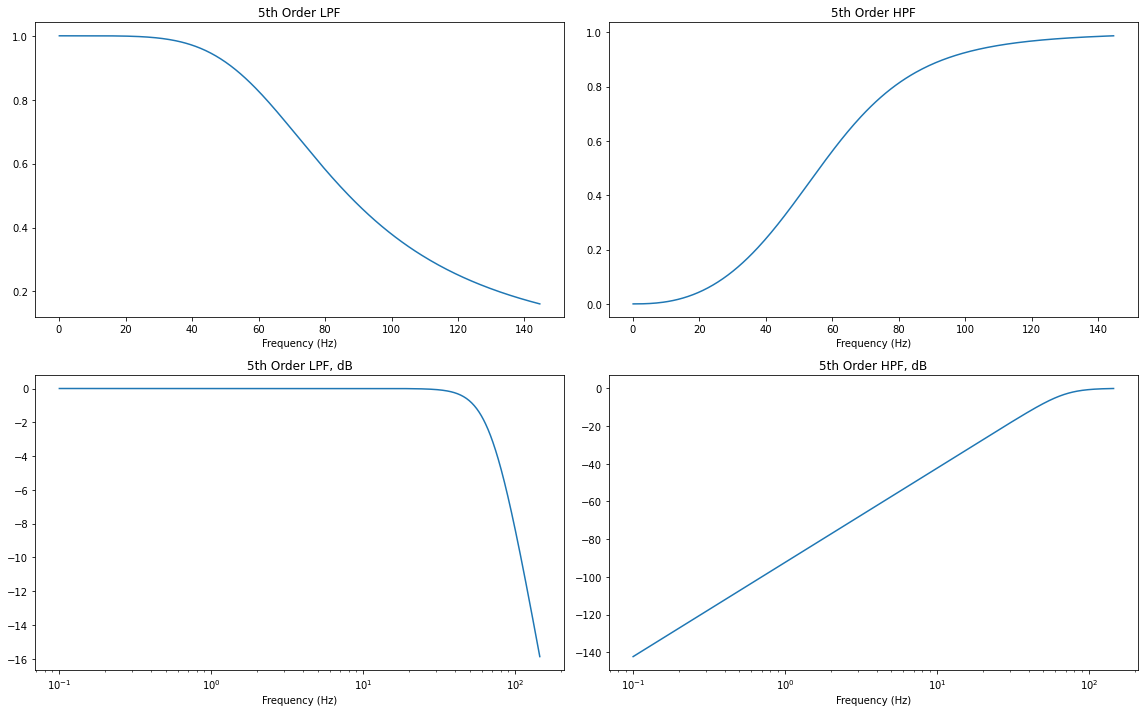

In [2]:
G_0 = 1                               # DC Gain of the filter 
N = 5                                 # Order of Butterworth filter 
f_c = 70                              # Cutoff frequency (Hz)
f = np.arange(0.1, 145, 0.5)          # Create frequency axis

H_LPF = G_0/np.sqrt(1+(f/f_c)**N)        # Low pass magnitude response 
H_HPF = G_0/np.sqrt(1+(f_c/f)**N)        # High pass magnitude response 

H_LPF_db = 20*np.log10(np.abs(H_LPF)) # dB
H_HPF_db = 20*np.log10(np.abs(H_HPF)) # dB

# -- Working out the figures
fig, axs = plt.subplots(2,2, figsize=(16,10))
axs[0,0].plot(f,H_LPF)
axs[0,0].set_title('5th Order LPF')
axs[0,0].set_xlabel('Frequency (Hz)')

axs[0,1].plot(f,H_HPF)
axs[0,1].set_title('5th Order HPF')
axs[0,1].set_xlabel('Frequency (Hz)')

axs[1,0].plot(f,H_LPF_db)
axs[1,0].set_title('5th Order LPF, dB')
axs[1,0].set_xlabel('Frequency (Hz)')
axs[1,0].set_xscale('log')

axs[1,1].plot(f,H_HPF_db)
axs[1,1].set_title('5th Order HPF, dB')
axs[1,1].set_xlabel('Frequency (Hz)')
axs[1,1].set_xscale('log')

fig.tight_layout() # Fixes figure layout 

We can see (especially from the log plots), that the Butterworth filters work very well for keeping a certain frequency band while attenuating every thing else -- note that the roll off for these filters is 40dB/decade -- which is significant attenuation. Just from these plots we can conceptually arrive at the first bass boosting implementation in this notebook. 

# Bass Boosting 

By considering the Butterworth filter graphs we can devise a simple bass booster as follows: Given an input audio file, pass the audio through the Butterworth LP and after obtaining the low frequency components, multiply them by a constant gain $G$; at the same time we pass the input audio to the Butterworth HPF to obtain the frequencies which will not be boosted; finally add the two songs together at the end and write a new .wav file. This is shown in the high level block diagram below.

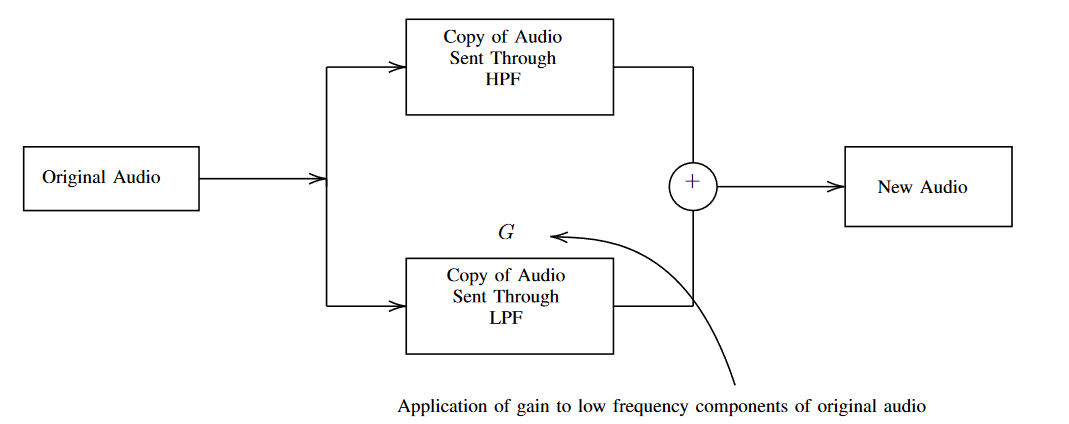

Recall that in (1), the ```lfilter``` function will implement these filters for us given that we can provide the vectors $b$ and $a$ which specify the filter. These can be derived by hand or we can utilize the scipy ```butter``` function which will return for us these vectors. For a low pass filter with cutoff frequency $f_c$ and for a sampling rate $fs$ we would have the following:

```Python
def low_pass_params(f_c, fs, order):
    
    # -- Nyquist Frequency 
    f_N = (1/2)*fs
    
    # -- Normalize cutoff to Nyquist frequency (largest frequency representable by our sampling rate)
    normal_cutoff = f_c/f_N
    
    # -- Obtain b, a vectors for low pass 5th order Butterworth filter with cutoff frequency f_c
    b, a = butter(order, normal_cutoff, btype = 'low', analog = False)

    return b, a
```

Its important that for the LPF the btype parameter is set to low and for the HPF the btype parameter is set to high. Also the analog parameter is False since we are implementing a digital filter design. Now all we need to do is pass the $b$ and $a$ vectors to the ```lfilter``` function and implement the block diagram in code on the sample audio file imported into this notebook. The sample audio file is displayed in the following cell -- the audio was cut to save space as .wav files can get pretty large.

**NOTE:** For this project a 32bit float encoded stereo .wav file is assumed. If a mono 32bit .wav file is entered a stereo signal will be created by copying the mono channel into left and right channels. If a .wav file is entered into the program with an encoding type which is not 32bit float the .wav writing function will not be able to write the audio file. 

In [ ]:
IPython.display.Audio('githubsample.wav')

In [ ]:
# -- Define all functions to be used in the bass booster implementation. 

def low_pass_params(f_c, fs, order):
    
    # -- Nyquist Frequency 
    f_N = (1/2)*fs
    
    # -- Normalize cutoff to Nyquist frequency (largest frequency representable by our sampling rate)
    normal_cutoff = f_c/f_N
    
    # -- Obtain b, a vectors for low pass 5th order Butterworth filter with cutoff frequency f_c
    b, a = butter(order, normal_cutoff, btype = 'low', analog = False)
    
    return b, a 


def high_pass_params(f_c, fs, order):
    
    # -- Nyquist Frequency 
    f_N = (1/2)*fs
    
    # -- Normalize cutoff to Nyquist frequency (largest frequency representable by our sampling rate)
    normal_cutoff = f_c/f_N
    
    # -- Obtain b, a vectors for high pass 5th order Butterworth filter with cutoff frequency f_c
    b, a = butter(order, normal_cutoff, btype = 'high', analog = False)    
    
    return b, a


def LPF_butter(data, f_c, fs, order):
    
    b, a = low_pass_params(f_c, fs, order)
    
    # -- Apply lowpass filter on input data sequence 
    LPF_data = lfilter(b, a, data)
    
    return LPF_data


def HPF_butter(data, f_c, fs, order):
    
    b, a = high_pass_params(f_c, fs, order)
    
    # -- Apply lowpass filter on input data sequence 
    HPF_data = lfilter(b, a, data)
    
    # -- Ensure lfilter did not promote to float 64
    HPF_data = np.asarray(HPF_data, dtype = np.float32)
    
    return HPF_data


def bass_boost(data, f_c, fs, G, length):
    
    # -- Ensure input data is float 32
    data = np.asarray(data, dtype = np.float32)
    
    # -- Apply LPF to data 
    data_low = LPF_butter(data, f_c, fs, order = 5)
    
    # -- Ensure output of lfilter is float 32 as it might promote to float 64
    data_low = np.asarray(data_low, dtype = np.float32)
    
    # -- Apply specified linear gain, G
    data_low = G*data_low
    
    return data_low


# -- Read in audio file and specify function parameters 
fs, song = wavfile.read('githubsample.wav')
N = len(song) # Length of one channel
f_c = 70
gain = 6.5 # Linear gain, I'd keep this under 10 to avoid possible headphone damage

# -- Check if song is mono and create stereo file if it is 
if np.size(np.shape(song)) == 1:
    
    left_channel = song 
    right_channel = song
    
    song = np.zeros((N, 2), dtype = np.float32)
    
    song[:, 0] = left_channel
    song[:, 1] = right_channel
    
# -- Proceed with stereo implementation 

left_channel_boost = bass_boost(song[:, 0], f_c, fs, gain, N)
right_channel_boost = bass_boost(song[:, 1], f_c, fs, gain, N)

left_channel_high = HPF_butter(song[:, 0], f_c, fs, order = 5)
right_channel_high = HPF_butter(song[:, 1], f_c, fs, order = 5)

left_channel = left_channel_boost + left_channel_high
right_channel = right_channel_boost + right_channel_high

# -- Create new empty stereo file
new_song = np.zeros((N, 2), dtype = np.float32)
new_song[:, 0] = left_channel
new_song[:, 1] = right_channel

# -- Write new bass boosted audio
wavfile.write('githubsample_boosted.wav', fs, new_song)

# -- Display new audio with IPython
IPython.display.Audio('githubsample_boosted.wav')

We can directly hear the difference. It's clear that this simple bass boost implementation worked and the result (on my headphones anyways) lacks the distortion or the equalization problems that are typical for bass boosted audio files. Let's proceed by taking a look at the PSD for the original song and for the boosted song. We will only compare the left channels, but the general effect would be the same for the right channel. 

In [ ]:
# -- Frequency axis 
freq = np.linspace(-fs/2, fs/2, N)

# -- Window 
w = np.blackman(N)

# -- Obtain frequency spectrum and PSD via FFT for the original left channel 
H_song = np.fft.fftshift(np.fft.fft(song[:, 0]*w)) 
H_song_PSD = 20*np.log10(np.abs(H_song)/N)

# -- Obtain frequency spectrum and PSD via FFT for the boosted left channel
H_song_boost = np.fft.fftshift(np.fft.fft(left_channel*w))
H_song_boost_PSD = 20*np.log10(np.abs(H_song_boost)/N)

# -- Plotting 
max_val = np.amax(H_song_boost_PSD)
min_val = np.amin(H_song_boost_PSD)

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].plot(freq, H_song_PSD)
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_title('PSD for Original Song')
axs[0].set_xlim(0, 350)
axs[0].set_ylim(min_val, max_val)

axs[1].plot(freq, H_song_boost_PSD)
axs[1].set_xlabel('Frequency(Hz)')
axs[1].set_title('PSD for Boosted Song')
axs[1].set_xlim(0, 350)


In the low frequency band we're seeing a gain of about 20 dB and we can see that as the frequency gets larger the signals become similar again. This is decent visual evidence of the success of this filter implementation and this was my first attempt at implementing a bass booster and I'm happy with the result. 

# Bonus (1): Shelving Filter Implementation

A more standard way to implement a bass boost would be through a [shelving filter](https://www.recordingblogs.com/wiki/shelving-filter). This is probably how digital bass boosts are achieved in consumer sound software. A low shelving filter has a gain, $G$ over the band $(0, f_c)$ and after $f_c$ the filter rolls off to 0dB gain, or rather a gain of unity. As per the website above, the second order shelving filter can be written in a form that can let us use ```lfilter``` again (see equation (1)). The second order shelving filter has transfer function 

\begin{equation} \tag{2}
H(z) = \frac{(1+\sqrt{2G}K + GK^2) + (-2+2GK^2)z^{-1} + (1-\sqrt{2G}K + GK^2)z^{-2}}{(1+\sqrt{2}K + K^2) + (-2+2K^2)z^{-1} + (1-\sqrt{2}K + K^2)z^{-2}}, \,\, K = \tan\left(\frac{\omega_c}{2}\right)
\end{equation} 

Here $K$ is a correction factor for the **biquad transformation** which is a special bilinear transformation which accounts for the frequency warping of the normal bilinear transformation. Essentially the factor $K$ helps us ensure that $f_c$ is implemented as close to specification as possible. 

Since this closed form is known, the vectors $b$ and $a$ which specify the filter for ```lfilter``` can easily be written given a user input gain and cutoff frequency:

$$ 
\begin{align*}
b_0 & = 1+\sqrt{2G}K\\
b_1 & = -2 + 2GK^2 \\
b_2 & = 1-\sqrt{2G}K + GK^2 \\
a_0 & = 1 + \sqrt{2}K + K^2 \\
a_1 & = -2 + 2K^2 \\
a_2 & = 1 - \sqrt{2}K + K^2 
\end{align*}
$$

As in the parameter functions in the first implementation, we can write a similar function for this implementation:

```Python

def low_shelf_params(K, G):
    
    b_0 = 1 + np.sqrt(2*G)*K + G*K**2
    b_1 = -2 + 2*G*K**2
    b_2 = 1 - np.sqrt(2*G)*K + G*K**2
    
    a_0 = 1 + np.sqrt(2)*K + K**2
    a_1 = -2 + 2*K**2
    a_2 = 1 - np.sqrt(2)*K + K**2
    
    b = np.array([b_0, b_1, b_2])
    a = np.array([a_0, a_1, a_2])
    
    return b, a 
```
And then these can easily be passed to ```lfilter``` to be applied to input audio. Let's implement this below: 

In [ ]:
# -- Define all functions to be used in this implementation 
def low_shelf_params(K, G):
    
    b_0 = 1 + np.sqrt(2*G)*K + G*K**2
    b_1 = -2 + 2*G*K**2
    b_2 = 1 - np.sqrt(2*G)*K + G*K**2
    
    a_0 = 1 + np.sqrt(2)*K + K**2
    a_1 = -2 + 2*K**2
    a_2 = 1 - np.sqrt(2)*K + K**2
    
    b = np.array([b_0, b_1, b_2])
    a = np.array([a_0, a_1, a_2])
    
    return b, a 


def low_shelf(data, N, K, G):
    
    b, a = low_shelf_params(K, G)
    
    # -- Apply shelving filter to input data channel
    bass_boosted_data = lfilter(b, a, data, axis = 0) # Wouldn't work without axis = 0 ?? 
    bass_boosted_data = np.asarray(bass_boosted_data, dtype = np.float32)
    
    return bass_boosted_data


# -- Read in input song again
fs, song = wavfile.read('githubsample.wav')

# -- Length of one channel
N = len(song)

# -- Cutoff frequency 
f_c = 65 # I liked the performance of this cutoff better for this implementation

# -- Gain
gain = 6.5 # Again I'd keep this lower than 10, it can be pushed higher than the first implementation though

# -- Nyquist frequency
f_N = (1/2)*fs 

# -- Normalized Cutoff 
normal_cutoff = (f_c/f_N)*np.pi # This pi factor is magic that makes this work. I have no idea why this fixed it
                                # considering that normalized frequencies would have pi factors divided out :/
# -- Adjust for frequency warp
K = np.tan(normal_cutoff/2)

# -- Check if song is mono and create stereo file if it is 
if np.size(np.shape(song)) == 1:
    
    left_channel = song 
    right_channel = song
    
    song = np.zeros((N, 2), dtype = np.float32)
    
    song[:, 0] = left_channel
    song[:, 1] = right_channel

# -- Proceed with stereo implementation

left_channel = low_shelf(song[:, 0], N, K, gain)
right_channel = low_shelf(song[:, 1], N, K, gain)

# -- Construct stereo audio
new_song = np.zeros((N, 2), dtype = np.float32)
new_song[:, 0] = left_channel
new_song[:, 1] = right_channel

# -- Write new audio
wavfile.write('githubsample_shelved.wav', fs, new_song)

# -- Display new audio
IPython.display.Audio('githubsample_shelved.wav')


I think the low shelf filter performs a bit better than the first implementation and it's more robust to higher gains. 

# Bonus (2): Implementing Shelving Filter Without Prebuilt Functions

While the use of ```lfilter``` greatly sped up the process of implementing my filter and the shelving filter, it is possible to implement the shelving filter without these external functions. While these naive implementations that I came up with don't come close to the speed of scipys filter function, this is a good exercise and could be helpful if one were to write DSP in C onto a MCU in the future and there may not be any prebuilt functions available to help.

We're going to take two approaches to implementing the shelving function: Firstly, implement the low shelf filter via the difference equation implicitly represented by equation (2). Secondly, implement the low shelf filter via the convolution of the unit impulse response of the shelving filter with the original data. The convolution in (2) will be implemented with the FFT and will therefore be much faster than the first method -- infact if the $h[n]$ of the filter was preloaded into a program, and a very fast convolution algorithm was implemented, I think the second method could approach the speed of the ```lfilter``` function. 

The transfer function given by (2) implicitly describes a finite difference equation which represents the relationship between the output $y[n]$ and the input $x[n]$. The equation also encodes any feedback in the system and any delays on the input. To find the finite difference equation (1) and that $H(z) = Y(z)/X(z)$:

$$H(z) = \frac{Y(z)}{X(z)} = \frac{b_0 + b_1z^{-1} + b_2 z^{-2}}{a_0 + a_1 z^{-1} + a_2z^{-2}} $$ 

This equation can be written in the following manner:

$$ a_0 Y(z) + a_1(z^{-1}Y(z)) + a_2(z^{-2}Y(z)) = b_0 X(z) + b_1(z^{-1}X(z)) + b_2(z^{-2}X(z)) $$

To obtain the time domain difference equation described by this equation we simply apply the inverse **Z transform** and utilize the following identity:

$$x(n-k) \iff z^{-k}X(z), \,\, k>0 $$ 

Then after some work and some algebra we obtain

\begin{equation}\tag{3}
y[n] = \frac{b_0}{a_0}x[n] + \frac{b_1}{a_0}x[n-1] + \frac{b_2}{a_0}x[n-2] - \frac{a_1}{a_0}y[n-1] - \frac{a_2}{a_0}y[n-2]
\end{equation}

This time difference equation describes exactly the filter given by (2). Meaning if $x[n]$ is our input audio, then we simply have to apply the recursion relation given by (3) to apply the filter. It's interesting to note that this type of filtering, at it's mathematical core, is given by simple recursion statements. 

Now since $n \in [0, N-1]$ where $N$ is the length of our input audio data, we need to be concerned about what happens at the points $n = 0, 1$, i.e we need to be concerned with $x(-1),y(-1), x(-2),y(-2)$. These values specify the **initial state** of the filter. For IIR filters (such as this shelving filter) it is typical to use **initial rest conditions**, meaning we specify the following conditions on the filter:

$$ x[n] = 0 \,\forall n \leq n_0 \text{ and } y[n] =0 \,\forall n \leq n_0$$

where $n_0$ is some chosen non-negative time index (in general choice of $n_0$ effects filter performance). For now we can choose $n_0=0$ and specify that $y(-1)=y(-2)=0$ and $x(-2)=x(-1)=0$. From these conditions we can immediately write:


\begin{align*}
n = 0: & y[0] = \frac{b_0}{a_0}x[0]\\
n = 1: & y[1] = \frac{b_0}{a_0}x[1] + \frac{b_1}{a_0}x[0] - \frac{a_1}{a_0}y[0]
\end{align*}

We can now proceed to crudely implement the recursion relation specified by (3) along with the conditions above with a ```for``` loop. 

In [ ]:
# -- Define low shelf filter via the recursive relationship above
def low_shelf_IIR(c, data, N):
    
    y = np.zeros(N, dtype = np.float32)
    y[0] = (c[0])*data[0]
    y[1] = (c[0])*data[1] + (c[1])*data[0] - (c[3])*y[0]
    
    for n in range(2, N):
        
        y[n] = (c[0])*data[n] + (c[1])*data[n-1] + (c[2])*data[n-2] - ((c[3])*y[n-1] + (c[4])*y[n-2])
    
    return y 


fs, song = wavfile.read('githubsample.wav')
N = len(song)
f_c = 65
f_N = (1/2)*fs
normal_cutoff = (f_c/f_N)*np.pi
gain = 6.5

# -- Adjust for frequency warp
K = np.tan(normal_cutoff/2)

# -- Check if song is mono and create stereo file if it is 
if np.size(np.shape(song)) == 1:
    
    left_channel = song 
    right_channel = song
    
    song = np.zeros((N, 2), dtype = np.float32)
    
    song[:, 0] = left_channel
    song[:, 1] = right_channel

# -- Proceed with stereo implementation

# -- Get low shelf parameters 
b, a = low_shelf_params(K, gain)

# -- Constants for recursion relation 
c_0 = b[0]/a[0]
c_1 = b[1]/a[0]
c_2 = b[2]/a[0]
c_3 = a[1]/a[0]
c_4 = a[2]/a[0]

# -- Constants in array format to pass into low shelf function
c = np.array([c_0, c_1, c_2, c_3, c_4])

left_channel = low_shelf_IIR(c, song[:, 0], N)
right_channel = low_shelf_IIR(c, song[:, 1], N)

new_song = np.zeros((N, 2), dtype = np.float32)

new_song[:, 0] = left_channel 
new_song[:, 1] = right_channel 

# -- Write song 
wavfile.write('githubsampleshelf1.wav', fs, new_song)

# -- Display song
IPython.display.Audio('githubsampleshelf1.wav')

This shelving filter should be identical to the one implemented with ```lfilter``` it just takes a bit longer. The next way we can do this is by finding the transfer function $h[n]$ for the filter and convolving it with the data. Theoretically this should increase the computational speed of the program as convolution can be implemented with the FFT via the ```fftconvolve``` function in scipy. There are faster convolution algorithms out there, but this one should still improve the performance of the program. 

Now: Finding $h[n]$. To find $h[n]$ we recall that it is the specific output to the input $x[n] = \delta[n]$, so to proceed we plug $x[n] = \delta[n]$ into (3):

\begin{equation}\tag{4}
h[n] = \frac{b_0}{a_0}\delta[n] + \frac{b_1}{a_0}\delta[n-1] + \frac{b_2}{a_0}\delta[n-2] - \frac{a_1}{a_0}h[n-1] -\frac{a_2}{a_0}h[n-2] 
\end{equation} 

This recursive relationship is also subject to the initial rest conditions that were placed on the general filter (3). The initial conditions will be different due to the behaviour of the $\delta$ sequences: 

\begin{align*}
h[0] & = \frac{b_0}{a_0} \\
h[1] & = \frac{b_1}{a_0} - \frac{a_1}{a_0} h[0]
\end{align*}

Let's fill out $h[n]$ in the next cell.

In [ ]:
# -- Get low shelf parameters 
b, a = low_shelf_params(K, gain)

# -- Constants for recursion relation 
c_0 = b[0]/a[0]
c_1 = b[1]/a[0]
c_2 = b[2]/a[0]
c_3 = a[1]/a[0]
c_4 = a[2]/a[0]

h = np.zeros(N, dtype = np.float32)
h[0] = c_0 
h[1] = c_1 - c_3*h[0]

delta = np.zeros(N, dtype = np.float32)
delta[0] = 1 

# -- Fill out the unit impulse response 
for n in range(2, N):
    
    h[n] = c_0*delta[n] + c_1*delta[n-1] + c_2*delta[n-2] - c_3*h[n-1] - c_4*h[n-2]

# -- Plotting stuff
plt.plot(h)
plt.xlim(0, 5)
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title('Unit Impulse Response of Low Shelf Filter')

print(h)

The graph above doesn't quite illustrate the unit impulse response well as it seems like it's only non-zero for $n=0$. However, the graph sits around $0.02$ for quite a bit of time before eventually decaying. 

All that remains is to apply convolution between the channels and this vector $h$. 

In [ ]:
# -- Define convolution based low shelf filter
def low_shelf_conv(data, h, N):
    
    y = fftconvolve(data, h)
    
    # -- Return first N elements as convolution returns N + M - 1 elements, M = len(h)
    y = y[: N]
    
    return y 


fs, song = wavfile.read('githubsample.wav')

N = len(song)

# -- Check if song is mono and create stereo file if it is 
if np.size(np.shape(song)) == 1:
    
    left_channel = song 
    right_channel = song
    
    song = np.zeros((N, 2), dtype = np.float32)
    
    song[:, 0] = left_channel
    song[:, 1] = right_channel
    
# -- Proceed with stereo implementation 

left_channel = low_shelf_conv(song[:, 0], h, N)
right_channel = low_shelf_conv(song[:, 1], h, N)

new_song = np.zeros((N, 2), dtype = np.float32)

new_song[:, 0] = left_channel
new_song[:, 1] = right_channel

# -- Write new audio
wavfile.write('githubsample_conv.wav', fs, new_song)

# -- Display new audio 
IPython.display.Audio('githubsample_conv.wav')

To wrap up I'll display all of the generated bass boosted tracks in their own cells below. 

In [ ]:
# -- Original Audio 
IPython.display.Audio('githubsample.wav')

In [ ]:
# -- Butterworth LPF and HPF Bass Booster 
IPython.display.Audio('githubsample_boosted.wav')

In [ ]:
# -- Low Shelf Bass Booster with scipy lfilter 
IPython.display.Audio('githubsample_shelved.wav')

In [ ]:
# -- Low Shelf Bass Booster with Time Difference Equation 
IPython.display.Audio('githubsampleshelf1.wav')

In [ ]:
# -- Low Shelf Bass Booster via Convolution of h[n] and Original Audio
IPython.display.Audio('githubsample_conv.wav')